# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
import re
!pip install -q wordcloud
!pip install torchmetrics
import wordcloud
from torch.utils.data import Dataset
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 
nltk.download('omw-1.4')
from torchtext.vocab import GloVe
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from IPython.core.display import Path
from gensim.scripts.glove2word2vec import glove2word2vec
import torch
import torch.nn as nn
from torchvision import datasets 
from torchvision.transforms import ToTensor
import torch.nn.functional as F 
from torch.utils.data import Dataset
from torch.utils.data import DataLoader , RandomSampler
import random
import os
os.environ['PYTHONHASHSEED'] = str(69)
from sklearn.metrics import classification_report, RocCurveDisplay, roc_curve, auc
from sklearn.metrics import f1_score 
from torchmetrics import ConfusionMatrix
!pip install transformers
from transformers import BertTokenizer, BertModel, BertTokenizerFast


Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 21.9 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 95.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 20.9 MB/s eta 0:00:00


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
def randreset(s):  #making sure each run will yield consistent results
	random.seed(s)
	np.random.seed(s)
	torch.manual_seed(s)
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False
	torch.cuda.manual_seed_all(s)
	os.environ['PYTHONHASHSEED'] = str(s)

## Bert Model

In [ ]:
bertmodel = 'bert-base-uncased'

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained(bertmodel)

Data Processing

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, X, Y, tokenizer, maxlen):
    self.X = []
    self.Y = []
    self.tokenizer = tokenizer
    self.maxlen = maxlen

    for (x,y) in zip(X,Y):
      self.X.append(self.tokenizer.encode_plus(x, add_special_tokens=True, max_length=self.maxlen, padding='max_length', truncation=True, return_tensors='pt' , return_token_type_ids=False, return_attention_mask=True).to(device))
      self.Y.append(torch.tensor(y, dtype=torch.long, device=device))

  def __len__(self):
    return len(self.Y)

  def __getitem__(self, index):
    return (self.X[index]['input_ids'], self.X[index]['attention_mask'], self.Y[index])
  

In [ ]:
path = '/content/drive/My Drive/AI2/HW3/imdb-reviews.csv'
df = pd.read_csv(path,  sep='\t', lineterminator='\n')

df['review'] = df['review'].apply(lambda r: re.sub(r'\'', '', r))   #removing apostrophes so don't becomes dont
df['review'] = [r.lower() for r in df['review'] ]   #making everything lowercase
df['review'] = df['review'].apply(lambda r: re.sub(r'<br /><br />', ' ', r))  #removing this wierd sequence found in some reviews
df['review'] = df['review'].apply(lambda r: re.sub(r'[^a-z]', ' ', r))   #only keeping letters
rem = stopwords.words('english')
df['review'] = df['review'].apply(lambda r: ' '.join([word for word in r.split() if word not in rem]))
# max = df['review'].map(lambda r: len(r.split())).max()
# print(max)  #1436   is the maximum review in words
 
X = list(df['review'].values)
Y = list(df['rating'].apply(lambda r: 1 if r > 5 else 0))

Xtrain, X1 , Ytrain, Y1 = train_test_split(X, Y, test_size=0.2, random_state=69)   #train test split
Xval, Xtest , Yval, Ytest = train_test_split(X1, Y1, test_size=0.5,random_state=69)


MODEL

In [ ]:
class BERTmodel(nn.Module):
  def __init__(self, dr, H, activation):
    super(BERTmodel, self).__init__()
    self.bertlayer = BertModel.from_pretrained(bertmodel).to(device)
    self.linear = nn.Sequential(
          nn.Linear(768, H, device=device),   #768 is the output of the bert model
          activation(),
		      nn.Dropout(dr),
          nn.Linear(H,2, device=device),
        )

  def forward(self, ids, mask):
    out = self.bertlayer(ids, mask)
    return self.linear(out[0][:, 0, :])

  def predict(self, dataloader):
    pred = torch.tensor([], device='cpu')
    true = torch.tensor([], dtype=torch.int, device='cpu')  #using tensors so I can control that they are in the cpu in order for sklearn's functions to not complain
    with torch.no_grad():
      self.eval()
      for (inputid, attentionmask, labels) in dataloader:
        _, y_pred = torch.max(self(inputid.squeeze(), attentionmask.squeeze()), 1)
        pred = torch.cat((pred, y_pred.cpu()))
        true = torch.cat((true, labels.squeeze().cpu()))
      return pred, true

def train(model, traindataloader, valdataloader, optimiser, learningrate, maxepochs):
  lastf1 = None
  opt = getattr(torch.optim, optimiser)(model.parameters(), lr=learningrate) 
  lossfunction = nn.CrossEntropyLoss()
  for epoch in range(maxepochs):
    model.train()
    t_losses = []
    for (inputid, attentionmask, labels) in traindataloader:
      opt.zero_grad()
      ypred = model(inputid.squeeze(), attentionmask.squeeze())
      loss = lossfunction(ypred, labels.squeeze())
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
      opt.step()

    pred, true = model.predict(valdataloader)
    f1 = f1_score(true, pred, average='weighted')
    print(f"for epoch: {epoch} we got val f1 score = {f1}")

    if lastf1 is None:    #stopping early if validation f1 does not improve
      lastf1 = f1
    else: 
      if lastf1 >= f1:
        break
      else:
        lastf1 = f1
  
  return model



# Testing

In [ ]:
batchsize = 32 #batch size
max = 250    #  max pading length
traind = CustomDataset(Xtrain, Ytrain, tokenizer, max)
vald = CustomDataset(Xval, Yval, tokenizer, max)
testd = CustomDataset(Xtest, Ytest, tokenizer, max)

train_dataloader = DataLoader(traind , batch_size=batchsize, sampler=RandomSampler(traind))
val_dataloader= DataLoader(vald , batch_size=batchsize,sampler=RandomSampler(vald))
test_dataloader = DataLoader(testd , batch_size=batchsize,sampler=RandomSampler(testd))

In [ ]:
randreset(666)
torch.cuda.empty_cache()

model = BERTmodel(0.5, 50, nn.ReLU)
model = train(model, train_dataloader, val_dataloader, "AdamW", 0.00003, 3)

torch.cuda.empty_cache()


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


for epoch: 0 we got val f1 score = 0.9041906176291601
for epoch: 1 we got val f1 score = 0.9017701463081031


In [ ]:
!pip install optuna

import optuna
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

def objective(trial):
  batchsize = trial.suggest_int('batchsize',30,64,step=2)
  maxpadding = trial.suggest_int('maxpadding', 150,250,step=2)
  lr = trial.suggest_float('lr', 1e-6,1e-4,step=1e-6)
  dropout = trial.suggest_float('dropout', 0.1,0.6,step=0.1)
  hidden = trial.suggest_int('hidden',50,256,step=2)
  activ = trial.suggest_categorical('activ', [nn.ReLU, nn.CELU])
  epochs = trial.suggest_int('epochs', 2,5)

  torch.cuda.empty_cache()

  traind = CustomDataset(Xtrain, Ytrain, tokenizer, maxpadding)
  vald = CustomDataset(Xval, Yval, tokenizer, maxpadding)
  testd = CustomDataset(Xtest, Ytest, tokenizer, maxpadding)

  train_dataloader = DataLoader(traind , batch_size=batchsize, sampler=RandomSampler(traind))
  val_dataloader= DataLoader(vald , batch_size=batchsize,sampler=RandomSampler(vald))
  test_dataloader = DataLoader(testd , batch_size=batchsize,sampler=RandomSampler(testd))

  randreset(666)


  model = BERTmodel(dropout, hidden, activ)
  model = train(model, train_dataloader, val_dataloader, "AdamW", lr, epochs)
  pred, true = model.predict(test_dataloader)
  f1 = f1_score(true, pred, average='weighted')
  del model
  return f1

study = optuna.create_study(direction="maximize")
study.optimize(objective, timeout=43200)



Due to memory overflows, I was unable to complete runs of optuna. Bellow there are the resaults of some trials.
 * Test parameters \\
 batchsize = 32, padding = 250, dropout = 0.5, hidden layer = 50, lr = 3e-5, maxepochs = 3, activation = Relu, F1->0.9017 \\ 

 * RUN 1 \\
 Trial 0 -> batchsize = 38, padding = 242, dropout = 0.1, hidden layer = 76, lr = 5.9e-05, maxepochs = 4, activation = Relu, F1->0.902 \\
 Trial 1 -> batchsize = 64, padding = 158, dropout = 0.2, hidden layer = 114, lr = 7.59e-05, maxepochs = 2, activation = Relu, F1->0.8971 \\
 Trial 2 -> batchsize = 48, padding = 208, dropout = 0.5, hidden layer = 80, lr = 4e-06, maxepochs = 2, activation = CELU, F1->0.8962 \\
 Trial 3 -> batchsize = 64, padding = 170, dropout = 0.2, hidden layer = 164, lr = 5.19e-05, maxepochs = 34, activation = CELU, F1->0.877 \\

 * RUN 2 \\
 Trial 0 -> batchsize = 32, padding = 194, dropout = 0.5, hidden layer = 130, lr = 2.6e-05, maxepochs = 2, activation = CELU, F1->0.903 \\

 * RUN 3 \\
 Trial 0 -> batchsize = 40, padding = 182, dropout = 0.1, hidden layer = 54, lr = 2.2e-05, maxepochs = 5, activation = CELU, F1->0.906 \\

TESTING BEST MODEL

In [ ]:
batchsize = 40 #batch size
max = 182    #  max pading length
traind = CustomDataset(Xtrain, Ytrain, tokenizer, max)
vald = CustomDataset(Xval, Yval, tokenizer, max)
testd = CustomDataset(Xtest, Ytest, tokenizer, max)

train_dataloader = DataLoader(traind , batch_size=batchsize, sampler=RandomSampler(traind))
val_dataloader= DataLoader(vald , batch_size=batchsize,sampler=RandomSampler(vald))
test_dataloader = DataLoader(testd , batch_size=batchsize,sampler=RandomSampler(testd))

In [ ]:
randreset(666)

model = BERTmodel(0.1, 54, nn.CELU)
model = train(model, train_dataloader, val_dataloader, "AdamW", 2.2e-05, 5)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


for epoch: 0 we got val f1 score = 0.8927191730516795
for epoch: 1 we got val f1 score = 0.9028041903153109
for epoch: 2 we got val f1 score = 0.904788249353872
for epoch: 3 we got val f1 score = 0.9033583402682421


test f1 score is 0.9064635491552044
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      2273
           1       0.91      0.90      0.91      2228

    accuracy                           0.91      4501
   macro avg       0.91      0.91      0.91      4501
weighted avg       0.91      0.91      0.91      4501



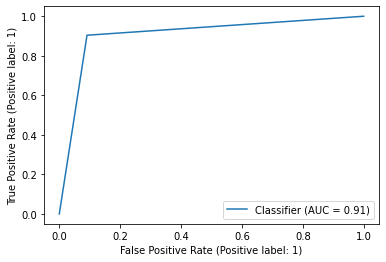

In [ ]:
#test

pred, true = model.predict(test_dataloader)
print(f"test f1 score is {f1_score(true, pred, average='weighted')}")
print(classification_report(true, pred))
RocCurveDisplay.from_predictions(true, pred)
plt.show()

In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/AI2/HW3/myNN.pt')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


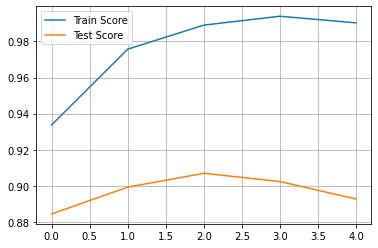

In [ ]:
def plotLC(model, traindataloader, testdataloader, optimiser, learningrate, maxepochs):
  trainf1 = []
  testf1 = []
  eps = []
  opt = getattr(torch.optim, optimiser)(model.parameters(), lr=learningrate) 
  lossfunction = nn.CrossEntropyLoss()
  for epoch in range(maxepochs):
    model.train()
    t_losses = []
    for batch in traindataloader:
      opt.zero_grad()
      ypred = model(batch['input_ids'].squeeze(), batch['attention_mask'].squeeze())
      loss = lossfunction(ypred, batch['labels'].squeeze())
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
      opt.step()

    eps.append(epoch)
    pred, true = model.predict(testdataloader)
    testf1.append(f1_score(true, pred, average='weighted'))
    pred, true = model.predict(traindataloader)
    trainf1.append(f1_score(true, pred, average='weighted'))

  plt.grid()
  plt.plot(eps, trainf1, label="Train Score")
  plt.plot(eps, testf1, label="Test Score")
  plt.legend()
  plt.show()

randreset(666)
model = BERTmodel(0.1, 54, nn.CELU)
plotLC(model, train_dataloader,  test_dataloader, "AdamW", 2.2e-05, 5)